## Applications of Linear Systems and Matrix Algebra


The need to solve linear systems arises in a wide variety of fields.  We show in this section an example of the linear system that arises in fitting a curve to a data set.  We also discuss the application of matrix algebra to cryptography and graph theory.

### Interpolation

Interpolation is the process of estimating unknown data values that fall between known values.  This process commonly involves fitting a curve through the known set of data points in order to make predictions about the unknown values.  The curve is described by a set of parameters, and "fitting the curve" means choosing the parameters such that the curve best represents the data.  A simple way to fit a curve is to require that it passes through all the data provided.  

Let's look at the the data points $(2,8)$, $(5,12)$, $(6,14)$, and $(15,15)$ as an example.

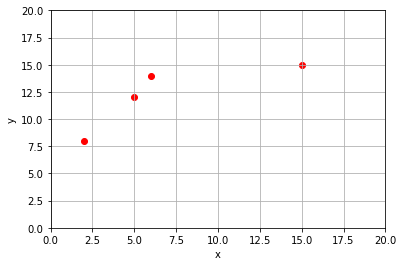

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import laguide as lag

x = np.array([2,5,6,15])
y = np.array([8,12,14,15])

fig,ax = plt.subplots()
ax.scatter(x,y,color='red');

ax.set_xlim(0,20);
ax.set_ylim(0,20);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.grid(True)

Polynomials are a common curve used for interpolation.  In this case, since we have four data points there will be four equations that must be satisfied for the graph to pass through each point.  We will choose a third degree polynomial, $P_3$, since that will give us four parameters with which to satisfy the equations.

$$
\begin{equation}
P_3(x) = a_0 + a_1x + a_2x^2 + a_3x^3
\end{equation}
$$

The data gives us the four equations $P_3(2) = 8$, $P_3(5) = 12$, $P_3(6) = 14$, and $P_3(15) = 15$.  This set of equations is a linear system for the unknown coefficients.


$$
\begin{eqnarray*}
a_0 + 2a_1 + 2^2a_2 + 2^3a_3 & = & 8\\
a_0 + 5a_1 + 5^2a_2 + 5^3a_3 & = & 12\\
a_0 + 6a_1 + 6^2a_2 + 6^3a_3 & = & 14\\
a_0 + 15a_1 + 15^2a_2 + 15^3a_3 & = & 15
\end{eqnarray*}
$$

We assemble the matrix $A$ and right-hand side vector $B$ as NumPy arrays.

In [6]:
A = np.zeros((4,4))
B = np.zeros((4,1))

for i in range(4):
    B[i,0] = y[i]
    for j in range(4):
        A[i,j] = x[i]**(j)
        
print(A,'\n')
print(B)

[[1.000e+00 2.000e+00 4.000e+00 8.000e+00]
 [1.000e+00 5.000e+00 2.500e+01 1.250e+02]
 [1.000e+00 6.000e+00 3.600e+01 2.160e+02]
 [1.000e+00 1.500e+01 2.250e+02 3.375e+03]] 

[[ 8.]
 [12.]
 [14.]
 [15.]]


Now we can solve the system $AX=B$ with elimination.  To avoid confusion with the $x$ variable, we will label our solution $\texttt{coeffs}$ since they represent the coefficients of the polynomial.

In [7]:
coeffs = lag.SolveSystem(A,B)
print(coeffs)

[[ 8.64102564]
 [-1.25555556]
 [ 0.52222222]
 [-0.02735043]]


Finally, we plot the graph of the polynomial over the data to see the fit. 

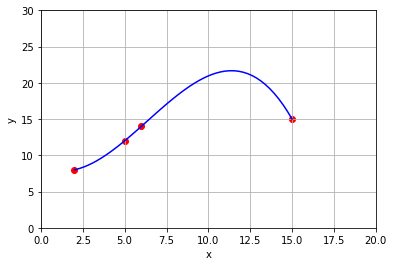

In [8]:
x_fit = np.linspace(x[0],x[3],50)
y_fit = coeffs[0] + coeffs[1]*x_fit + coeffs[2]*x_fit**2 + coeffs[3]*x_fit**3

fig,ax = plt.subplots()

ax.scatter(x,y,color='red');
ax.plot(x_fit,y_fit,'b');
ax.set_xlim(0,20);
ax.set_ylim(0,30);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.grid(True);

Although the curve that we produce does indeed pass through each of the data points, this polynomial may not be the best model of the underlying process.  One potential concern is that the curve does not seem to connect the third and fourth data point in a direct way, but rather exhibits an oscillation.  When constructing a curve to fit a set of data points, there are other factors that may be more important than simply requiring that the curve passes through each point.  In a later chapter we will revisit the problem and consider the idea of finding a curve that "fits" the data without actually passing through each point. 

#### Exercises

**Exercise 1:** In 2017, researchers from the Universities of British Columbia, Alberta, and Toronto published their findings regarding the population of snowshoe hares around Kluane Lake, Yukon. They measured the density of hares per hectare, taking a reading once every two years. Here are some of their measurements:

| Measurement #    | Density per ha. |
| ---------------- | --------------- |
| 1                | 0.26            |
| 2                | 0.20            |
| 3                | 1.17            |
| 4                | 2.65            |
| 5                | 0.14            |
| 6                | 0.42            |
| 7                | 1.65            |
| 8                | 2.73            |
| 9                | 0.09            |
| 10               | 0.21            |

$(a)$ Find the unique ninth degree polynomial whose graph passes through each of these points.  Plot the data points together with the graph of the polynomial to observe the fit.
   
$(b)$ Using the polynomial that we found, what should we expect the density of hares to be if we measured their population in the year between the third and fourth measurement? What about between the fourth and the fifth?
 
$(c)$ Why might this method of interpolation not be an appropriate model of our data over time?

In [ ]:
## Code solution here.

**Exercise 2:** The further you travel out into the solar system and away from the Sun, the slower an object must be travelling to remain in its orbit. Here are the average radii of the orbits of the planets in our solar system, and their average orbital velocity around the Sun.

|Planet                           | Distance from Sun (million km)  | Orbital Velocity (km/s)         |
| ------------------------------- | ------------------------------- | ------------------------------- |
|Mercury                          | 57.9                            | 47.4                            |
|Venus                            | 108.2                           | 35.0                            | 
|Earth                            | 149.6                           | 29.8                            |
|Mars                             | 228.0                           | 24.1                            |
|Jupiter                          | 778.5                           | 13.1                            |
|Saturn                           | 1432.0                          | 9.7                             |
|Uranus                           | 2867.0                          | 6.8                             |
|Neptune                          | 4515.0                          | 5.4                             |

$(a)$ Find the unique first degree polynomial whose graph passes through points defined by Mercury and Jupiter.  Plot the data points together with the graph of the polynomial to observe the fit. Amend your polynomial and graph by adding Saturn, and then Earth. What do you notice as you add more points? What if you had started with different planets?
   
$(b)$ Expand your work in part $(a)$ to a seventh degree poynomial that passes through all eight planets. The first object in the Kuiper Belt, Ceres, was discovered by Giuseppe Piazzi in 1801. Ceres has an average distance from the sun of 413.5 million km. Based on the points on the graph, estimate the orbital velocity of Ceres. What does the polynomial suggest the value would be?

In [ ]:
## Code solution here.

### Cryptography

One of the primary goals of cryptography is to secure communications by encoding messages.  The encoded message is difficult to read by anyone except for the intended recipient, who possesses some secret knowledge that allows them to reverse the process and decode the message.  The original message is known as _plaintext_, and the encoded message is known as _ciphertext_.  We demonstrate here the well-known Hill Cipher, which is a method of transforming plaintext to ciphertext using familiar matrix multiplication.

#### Encryption

Let's assume that the plaintext and ciphertext will be made up of characters from the same predefined _alphabet_.  This alphabet can contain letters, numbers, punctuation, and any number of other symbols that might be appropriate.  We also need a square invertible matrix $B$, called the encryption matrix.  Given these parameters, we take the following steps to get from plaintext to ciphertext.

1. Translate the plaintext from alphabet characters into a list of numbers.
2. Divide the list of numbers into a collection of $N\times 1$ vectors.  Use these numbers as columns in a plaintext array $P$.
3. Apply the cipher by multiplying each vector by the matrix $B$.  This produces a ciphertext array $C=BP$.
4. Translate the columns of $C$ back into a string of alphabet characters.

In order to get started, we first need a way to transform a message that includes letters, numbers, and possibly other characters, into to a message that consists of only numbers.  The easiest thing to do is to substitute each possible character in the message for a number.  For example we might let A=1, B=2, C=3, and so on.  In order to make this process less obvious, we might scramble the order of the numbers (A=23, B=5, C=12, ...), or substitute single numbers for common groups of letters (TH=32, EE=20, ING=17, ...).  However we choose to convert our message from text to numbers, there will still be patterns that remain among the numbers due to the natural patterns of the underlying language.  

For the purpose of this demonstration, we will make use of a list named $\texttt{alphabet}$ to convert between letters and numbers.  This list is included in the $\texttt{hillcipher}$ module, which contains some other functions that we will need.  If we print the list, we can see that it contains a space, a period, a question mark, and all uppercase letters.   

In [9]:
import hillcipher as hc
print(hc.alphabet)

[' ', '.', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


To find which character goes with which number, we can use the number as an index to the list as usual.

In [10]:
num = 2
char = hc.alphabet[num]
print("The character",char,"is associated with the number",num,".")

The character ? is associated with the number 2 .


To find which number is associated with each letter, we need to look up the index for that letter. 

In [11]:
char = 'R'
num = hc.alphabet.index(char)
print("The number",num,"is associated with the character",char,".")

The number 20 is associated with the character R .


Note that the code in the first cell will produce an error if we choose an index that is larger than 28, and the code in the second cell will produce an error if we choose a letter that is not in $\texttt{alphabet}$. 

To complete this step of the encryption, we write a loop that builds a list of numbers corresponding to each letter in a message and define a NumPy array based on that list.

In [12]:
plaintext = "WE DONT HAVE NUMBERS IN OUR ALPHABET.  WE HAVE TO SPELL TWO."
number_message = []
    
for char in plaintext:
    number_message.append(hc.alphabet.index(char))
    
array_message = np.array(number_message)
print(array_message)

[25  7  0  6 17 16 22  0 10  3 24  7  0 16 23 15  4  7 20 21  0 11 16  0
 17 23 20  0  3 14 18 10  3  4  7 22  1  0  0 25  7  0 10  3 24  7  0 22
 17  0 21 18  7 14 14  0 22 25 17  1]


The next step is to arrange our numerical message into the plaintext array $P$ which must have dimensions compatible with our encryption matrix $B$.  We will choose $B$ to be a $4\times 4$ matrix for this example.

$$
B = \left[ \begin{array}{rrrr} 1 & 0 & -2 & -1 \\ 3 & -1 & -3 & 2 \\ 2 & 0 & -4 & 4 \\ 2 & 1 & -1 & -1 \end{array}\right]
$$

We now take the plaintext message and break it into chunks which contain 4 numbers each.  (*Note that if the number of characters in our message is not divisible by 4, we can add extra characters at the end.*)  Each chunk will form a column of $P$, and we will have as many columns as needed to accommodate the entire message.  We make use of the $\texttt{reshape}$ and $\texttt{transpose}$ methods to manipulate the entries in the array.

In [13]:
# Find the number of chucks needed.
chunks = int(len(number_message)/4)
P = array_message.reshape((chunks,4))
P = P.transpose()
print(P)

[[25 17 10  0  4  0 17  3  3  1  7 24 17  7 22]
 [ 7 16  3 16  7 11 23 14  4  0  0  7  0 14 25]
 [ 0 22 24 23 20 16 20 18  7  0 10  0 21 14 17]
 [ 6  0  7 15 21  0  0 10 22 25  3 22 18  0  1]]


The next step is one multiplication multiplication. 

In [14]:
B = np.array([[1,0,-2,-1],[3,-1,-3,2],[2,0,-4,4],[2,1,-1,-1]])
C = B@P
print(C)

[[ 19 -27 -45 -61 -57 -32 -23 -43 -33 -24 -16   2 -43 -21 -13]
 [ 80 -31 -31 -55 -13 -59 -32 -39  28  53  -3 109  24 -35  -8]
 [ 74 -54 -48 -32  12 -64 -46 -26  66 102 -14 136  22 -42 -20]
 [ 51  28  -8 -22 -26  -5  37  -8 -19 -23   1  33  -5  14  51]]


The final task is to translate the numbers in $C$ back to characters of the alphabet.  This step requires a bit more thought since most of the numbers in $C$ are outside the index range of the alphabet (0-28).  We can let these numbers be associated with letters by letting the count wrap around at 29.  That is, 29 is associated with the same character as 0, 30 is associated with the same character as 1, and so forth.  We can also let -1 be associated with the same character as 28, -2 be associated with the same character as 27, and so forth to address negative numbers.  This concept is known as *congruence* in *modular arithmetic* and is performed using the $\texttt{%}$ operator in Python.  Try it out!   

In [15]:
print(80%29)

22


With that detail in place, we can step through the elements of $C$ and generate the final encrypted message from the characters in our alphabet.  

In [16]:
# We begin with an empty string and add one character for each entry in C
encrypted_message = ''

for j in range(C.shape[1]):  # For each column j ...
    for i in range(C.shape[0]):  # ... we step through each row i and add a letter for that entry
        encrypted_message = encrypted_message + hc.alphabet[C[i,j]%29]
        
print(encrypted_message)

QTNT?YBZKYHSXAXE.NJAXZUVDXJFMQASWZFHCVMDKXM.?TRBMVTVFUNLNSGT


Notice that this last step of the process cannot be reversed.  It is not possible to start with the encrypted message and determine the ciphertext array $C$.  Indeed, there are an infinite number of matrices that could have generated this same encrypted message since any of the entries can be have a multiple of 29 added to it.

#### Decryption

If the encryption matrix $B$ is known, we might hope to multiply by the inverse matrix to determine the plaintext array $P = B^{-1}C$.  As we just noted however, we cannot reconstruct $C$ from the encrypted message.  To overcome this difficulty, we need to find the *modular inverse* of the matrix $B$.  That is, we need a matrix $B^{-1}$ such that the entries of $B^{-1}B$ are congruent to the entries of $I$ in the modular arithmetic.  (*Note that we use the same symbol for the modular inverse as we do for the usual inverse matrix.*)

The method for finding the modular inverse is beyond our scope, but we will make use of the $\texttt{ModularInverseMatrix}$ function in the $\texttt{hillcipher}$ module to calculate $B^{-1}$ for the purpose of demonstration.

In [17]:
B_inv = hc.ModularInverseMatrix(B)
print(B_inv,'\n')
print(B_inv@B,'\n')
print((B_inv@B)%29)

[[-300  300 -150  300]
 [-150 -450  300  450]
 [-450  150 -150  150]
 [-300    0  150    0]] 

[[900   0   0   0]
 [  0 900   0   0]
 [  0   0 900   0]
 [  0   0   0 900]] 

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


What is important to observe here is that $B^{-1}B$ is not exactly $I$, but is congruent to $I$ if we work out the equivalent number between 0 and 28 for each entry.  To proceed with the decryption, we assemble the encrypted message into an array (we call it $\texttt{decryptionC}$ to avoid confusion) and multiply by $B^{-1}$. 

In [18]:
number_of_columns = int(len(encrypted_message)/4)
decryptionC = np.zeros((4,number_of_columns),dtype='int')

# For each column, we step down the column and fill in with the characters of the encrypted messsage.

k = 0
for j in range(number_of_columns):  
    for i in range(4):
        decryptionC[i,j] = hc.alphabet.index(encrypted_message[k])
        k += 1

decryptionP = B_inv@decryptionC
        
print(decryptionC)
print('\n')
print(decryptionP)

[[19  2 13 26  1 26  6 15 25  5 13  2 15  8 16]
 [22 27 27  3 16 28 26 19 28 24 26 22 24 23 21]
 [16  4 10 26 12 23 12  3  8 15 15 20 22 16  9]
 [22 28 21  7  3 24  8 21 10  6  1  4 24 14 22]]


[[  5100  15300   9000  -8700   3600   4350   6600   7050   2700   5250
    1950   4200   6600   6300   6750]
 [  1950   1350  -1650   5700  -2400   1200  -5400   -450  -9450  -4350
   -8700  -2400   4350   -450    750]
 [ -4350   6750   -150 -14100    600  -7350    600  -1200  -6750      0
   -4050      0  -2850   -450  -2100]
 [ -3300      0  -2400  -3900   1500  -4350      0  -4050  -6300    750
   -1650   2400  -1200      0  -3450]]


Again, multiplication by $B^{-1}$ produces numbers that are outside of the range 0-28, so again we apply modular congruence before translating the numbers back into characters in the alphabet.

In [19]:
decrypted_message = ''
for j in range(number_of_columns):
    for i in range(4):
        decrypted_message = decrypted_message + hc.alphabet[decryptionP[i,j]%29]

print(decrypted_message)

WE DONT HAVE NUMBERS IN OUR ALPHABET.  WE HAVE TO SPELL TWO.


#### Exercises

The $\texttt{hillcipher}$ module contains two functions that carry out the same steps we have demonstrated here to encrypt/decrypt a message using the included alphabet.  The following cell shows how they are called.

In [20]:
msg = "Water in short supply.  Send help soon!"
en_msg = hc.HillCipherEncryption(msg,B)
print(en_msg)

de_msg = hc.HillCipherDecryption(en_msg,B)
print(de_msg)

! is not included in the current alphabet.
ARQVI.?KSJZUZTFJ?W.AYTWXJR?Y.XZPOWRYLUIB
WATER IN SHORT SUPPLY.  SEND HELP SOONM?


Note that these functions do some error checking of the original message to be sure that all letters are in uppercase, and no characters outside the alphabet are included in the message that gets encrypted.

**Exercise 1:** Create your own encryption matrix and apply the steps above to encrypt a message of your choosing.  Check the results with those produced by $\texttt{HillCipherEncryption}$.

In [21]:
## Code solution here.

**Exercise 2:** Create your own alphabet list to translate messages into numbers.

In [22]:
## Code solution here.

### Graph Theory

A **directed graph** is defined as a set of nodes together with ordered pairs of nodes which define directed edges.  For example, a graph might consist of nodes labeled 0, 1, 2, and 3, and edges (0,1), (1,3), (2,0), (2,1), and (3,1).    The graph can be visualized using points for the nodes and arrows for the edges.

![title](img/Graph_example.png)

Graphs may be used to represent many types of information.  The nodes might represent hubs in a transportation network (such as airports), and the edges the possible routes (flights) available in the network.  The nodes could also represent players in a tournament, with the edges representing results of individual competitions between the players.  The nodes might also represent units of interconnected computer code, with the edges indicating how each unit depends on the others.

A graph can be described using an **adjacency matrix** $A$.  The entries $a_{ij}$ of the matrix are 1 if there is an edge from node $i$ to node $j$ and 0 otherwise.        

In [23]:
A = np.array([[0,1,0,0],[0,0,0,1],[1,1,0,0],[0,1,0,0]])
print(A)

[[0 1 0 0]
 [0 0 0 1]
 [1 1 0 0]
 [0 1 0 0]]


For the visualizations we use functions included in the $\texttt{laguide}$ module.  These functions make use of $\texttt{matplotlib}$ and a module called $\texttt{networkx}$.  The first function we will use is called $\texttt{DrawGraph}$, which requires an adjacency matrix in the form of a NumPy array.  

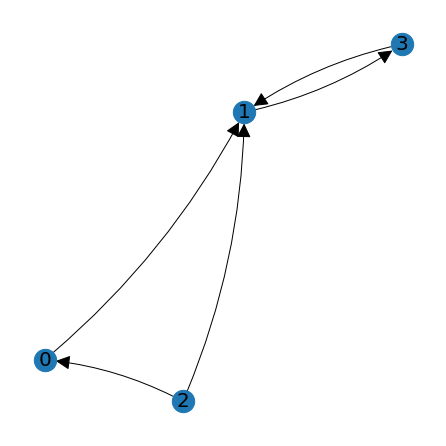

In [24]:
node_positions = lag.DrawGraph(A)

The function produces a visualization with $\texttt{matplotlib}$, and then returns a Python object containing the positions of the nodes used in making the picture.  Notice that the nodes in this picture are in a different arrangement than in the first picture.  Both pictures represent the same graph so long as edges connect the nodes in the same way.  When we call the function $\texttt{DrawGraph}$, it will generate suitable positions for the nodes *unless we supply it with pre-defined positions.*  We only need to use supply node positions if we want to replicate previous node positions, or if we draw additional features on a graph under consideration.

We demonstrate here with two examples.  If we use $\texttt{DrawGraph}$ this way
```
old_node_positions = lag.DrawGraph(A,node_positions)
```
we will get an exact copy of the previous picture, and $\texttt{old_node_positions}$ will be a copy of $\texttt{node_positions}$.

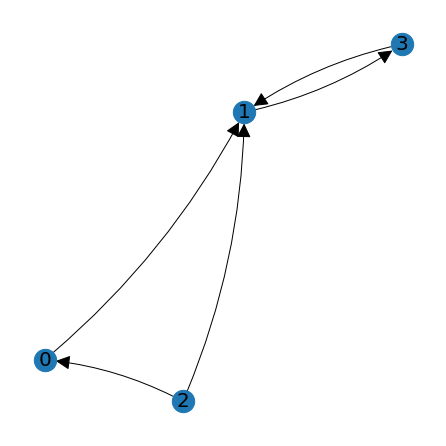

In [25]:
old_node_positions = lag.DrawGraph(A,node_positions)

If we use $\texttt{DrawGraph}$ this way
```
new_node_positions = lag.DrawGraph(A)
```
the function generates a new set of positions and draws a different, but equivalent, picture.

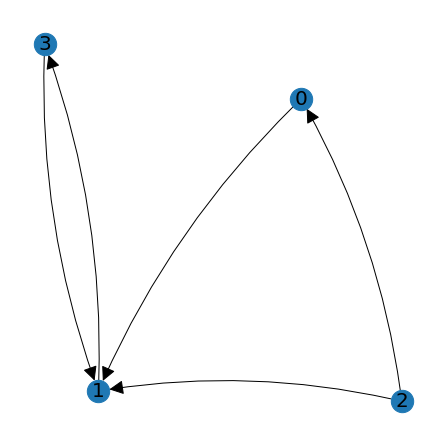

In [26]:
new_node_positions = lag.DrawGraph(A)

For the discussion in this section we will place two restrictions on the edges.

1.  No edges will be allowed from a node to itself.
2.  No edges will be repeated.

The first restriction means that the adjacency matrix will have zeros along the main diagonal.  

Here is another example of a graph, this one with six nodes.

[[0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 0 0 1 1]
 [1 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 0 0 0 1 0]]


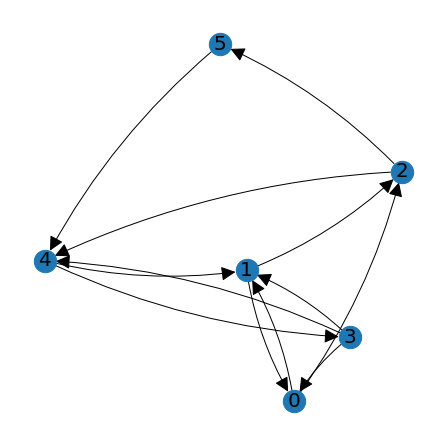

In [27]:
B = np.array([[0,1,1,0,0,0],[1,0,1,0,0,0],[0,0,0,0,1,1],[1,1,0,0,1,0],[0,1,0,1,0,0,],[0,0,0,0,1,0]])
print(B)
node_positions = lag.DrawGraph(B)

#### Counting paths

One use of the adjacency matrix is in computation of paths from one node to another.  The $(i,j)$ entries in *powers* of the adjacency matrix will tell us the number of paths between nodes $i$ and $j$ that have length equal to the power.  For example, if $B$ is the adjacency matrix, then $B^3$ contains information about paths of length 3.  

Let's try it out for the previous example.   

In [28]:
print(B@B@B)

[[0 2 1 1 2 1]
 [1 1 1 1 2 1]
 [2 2 1 1 1 0]
 [3 2 3 0 3 2]
 [1 3 3 1 1 1]
 [2 1 1 0 1 0]]


We see for example that $B^3_{50} = 2$.  This means that there are 2 paths of length 3 from node 5 to node 0.  Similarly we see that $B^3_{22} = 1$, which means that there is only 1 path of length 3 from node 2 back to itself.  Check the graph for yourself to verify these counts.   

#### Finding cliques

A **clique** is a set of three or more nodes within a graph such that there is an edge between each node in the clique *in both directions*.  In the example shown below, nodes 2, 3, and 4 form a clique.

![title](img/Clique_example.png)

Note that node 1 in this graph is not part of the clique because it is not connected in both directions to nodes 2 and 4.  In order for a node to be included in the clique, it must be connected in both directions to *every other node in the clique.*

Identifying cliques in large graphs is a difficult problem.  A graph may contain many cliques, and it may be that some nodes belong to multiple different cliques.  If in the previous example there were an edge from node 2 to node 1, then the graph would have a clique made up of nodes 1, 2 and 3, as well as the clique made up of nodes 2, 3 and 4.

![title](img/Clique_example2.png)

Counting paths using adjacency matrices can be used as a way to identify which nodes are in cliques.  Since these nodes must be connected to other clique nodes in both directions, we will only allow steps in the paths between nodes that are connected by edges in both directions.  If a node is in a clique, there is at least one such path of length 3 that starts and ends at that node.

Starting with an adjacency matrix $A$, we have a two step process:

1. Build an adjacency matrix $C$ that includes only the edges between nodes that are connected in both directions.  That is, $c_{ij} = 1$ only if $a_{ij} = 1$ and $a_{ji}=1$.
2. Use $C^3$ to identify which nodes have paths to themselves of length 3.  That is, check which entries on the main diagonal of $C^3$ are nonzero.

[[0 1 1 1 0 0]
 [1 0 1 1 0 0]
 [0 0 0 0 1 1]
 [1 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 0 0 0 1 0]]


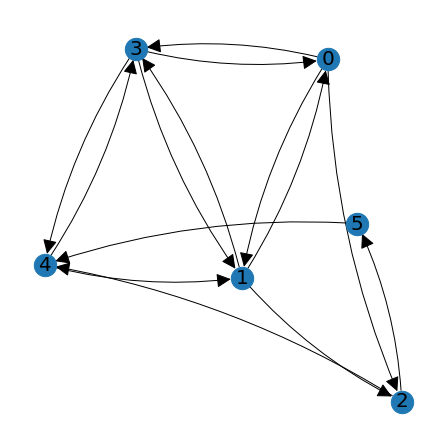

In [29]:
A = np.array([[0,1,1,1,0,0],[1,0,1,1,0,0],[0,0,0,0,1,1],[1,1,0,0,1,0],[0,1,0,1,0,0,],[0,0,0,0,1,0]])
print(A)
node_positions = lag.DrawGraph(A)

In [30]:
C = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        if (A[i,j] == 1 and A[j,i] == 1):
            C[i,j] = 1
print(C)
print('\n')
print(C@C@C)

[[0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


[[2. 3. 0. 4. 1.]
 [3. 2. 0. 4. 1.]
 [0. 0. 0. 0. 0.]
 [4. 4. 0. 2. 3.]
 [1. 1. 0. 3. 0.]]


We can see from the result that nodes 0, 1, and 3 are clique nodes.  Since there are only three such nodes, they all must be in the same clique.  We can highlight the clique nodes using the function $\texttt{HighlightSubgraph}$, which works similarly to $\texttt{DrawGraph}$ but also accepts a list of nodes to highlight.

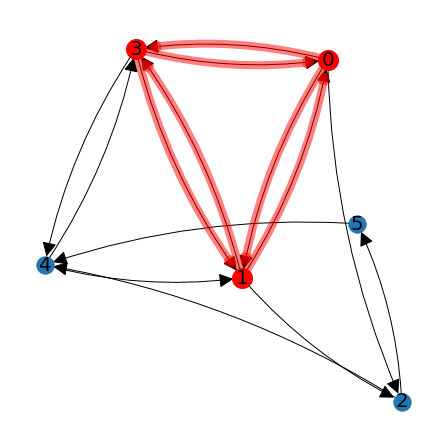

In [31]:
lag.HighlightSubgraph(A,node_positions,[0,1,3])

Let's try one more example with a larger graph that we build at random.

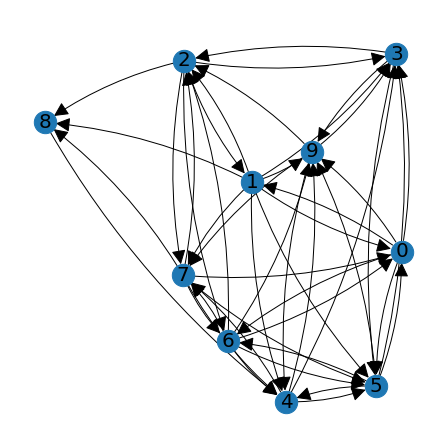

In [32]:
import random

N = 10
R = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if(random.random() > 0.5 and i != j):
            R[i,j] = 1
            
big_graph_positions = lag.DrawGraph(R)

[[2. 5. 3. 3. 2. 6. 7. 4. 0. 2.]
 [5. 0. 6. 1. 2. 3. 2. 2. 0. 1.]
 [3. 6. 2. 7. 4. 4. 9. 6. 0. 1.]
 [3. 1. 7. 0. 1. 8. 2. 4. 0. 5.]
 [2. 2. 4. 1. 0. 8. 2. 6. 0. 5.]
 [6. 3. 4. 8. 8. 2. 9. 3. 0. 0.]
 [7. 2. 9. 2. 2. 9. 4. 7. 0. 4.]
 [4. 2. 6. 4. 6. 3. 7. 2. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 1. 1. 5. 5. 0. 4. 1. 0. 0.]]


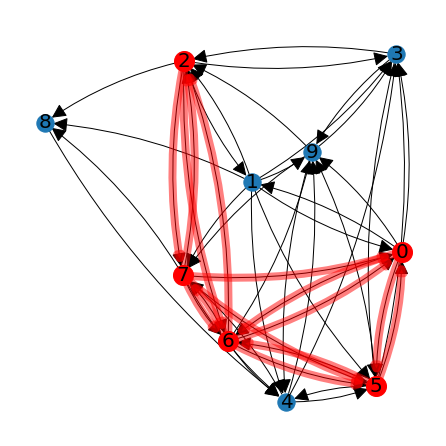

In [33]:
C = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if (R[i,j] == 1 and R[j,i] == 1):
            C[i,j] = 1

C_3 = C@C@C            
clique_nodes = []
for i in range(N):
    if (C_3[i,i] != 0):
        clique_nodes.append(i)
print(C_3)
lag.HighlightSubgraph(R,big_graph_positions,clique_nodes)

Although the exact picture will change with each new random matrix, we will likely see that there are more than three nodes in the list $\texttt{clique_nodes}$, and that this set of nodes defines more than one clique.  For a graph with 10 nodes, we can still see fairly easily how to sort the nodes into different cliques.  For large graphs we would want to make use of a sorting algorithm.

#### Tournament analysis

In a **dominance directed graph** every node is connected to each other node, but only in one direction.  This means the in the adjacency matrix $D$, either $d_{ij} = 1$, or $d_{ji}=1$, but not both.  A dominance directed graph could be used to represent the results of a tournament where every player faced each other player exactly once, and either won or lost the competition.  An edge from player 2 to player 4 means that player 2 won.  Let's look at an example.  

[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 1 0 1 1]
 [1 1 0 0 1]
 [1 0 0 0 0]]


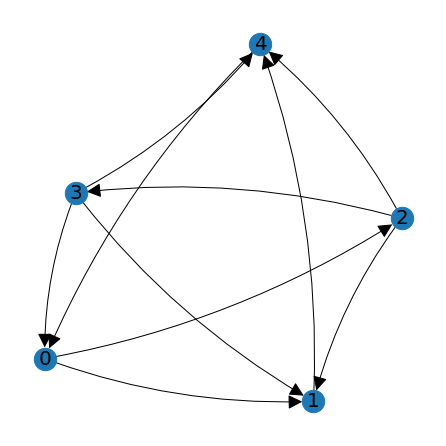

In [34]:
D = np.array([[0,1,1,0,0],[0,0,0,0,1],[0,1,0,1,1],[1,1,0,0,1],[1,0,0,0,0]])
print(D)
positions = lag.DrawGraph(D)

In this scenario the sum of the rows of $D$ indicate how many wins were earned by each player.  In the example, players 2 and 3 both earned 3 wins, player 0 earned 2 wins, and players 1 and 4 earned a single win each.  In order to distinguish the tournament standings between players 2 and 3, we might also look at all the two-step paths between players using the matrix $D^2$.

In [35]:
print(D@D)

[[0 1 0 1 2]
 [1 0 0 0 0]
 [2 1 0 0 2]
 [1 1 1 0 1]
 [0 1 1 0 0]]


The number of two-step paths from player 2 represents the number of wins among the players that were defeated by player 2.  Thus if we want to determine a player's tournament standing based not only on their number of wins, but also on the relative standings of the players they defeated, we can add the number of one-step paths (direct wins) to the number of two-step paths (indirect wins).   

In [36]:
print(D + D@D)

[[0 2 1 1 2]
 [1 0 0 0 1]
 [2 2 0 1 3]
 [2 2 1 0 2]
 [1 1 1 0 0]]


Looking at the sum of the rows of $D + D^2$ we see that player 2 has the highest rating in this particular tournament.

#### Exercises

**Exercise 1:** Create your own adjacency matrix and use $\texttt{DrawGraph}$ to make a visualization of the associated graph.

**Exercise 2:** Edit your matrix and redraw the graph to see the changes.  Reuse the positions if you want the nodes to remain in the same locations.

**Exercise 3:** Rerun the code in the two cells below until it produces a graph that has at least 5 nodes in the list $\texttt{clique_nodes}$.  Sort the nodes if they belong to different cliques.

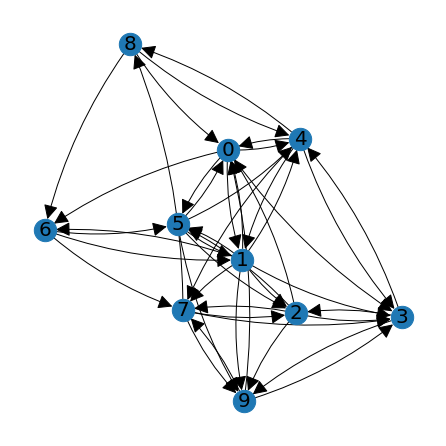

In [37]:
N = 10
R = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if(random.random() > 0.5 and i != j):
            R[i,j] = 1
            
big_graph_positions = lag.DrawGraph(R)

[[4. 6. 2. 2. 7. 6. 2. 1. 1. 1.]
 [6. 4. 2. 2. 8. 7. 4. 1. 1. 1.]
 [2. 2. 0. 6. 2. 5. 1. 5. 1. 0.]
 [2. 2. 6. 0. 6. 2. 1. 0. 0. 5.]
 [7. 8. 2. 6. 2. 3. 1. 2. 4. 0.]
 [6. 7. 5. 2. 3. 2. 1. 0. 2. 2.]
 [2. 4. 1. 1. 1. 1. 0. 0. 1. 0.]
 [1. 1. 5. 0. 2. 0. 0. 0. 0. 4.]
 [1. 1. 1. 0. 4. 2. 1. 0. 0. 1.]
 [1. 1. 0. 5. 0. 2. 0. 4. 1. 0.]]


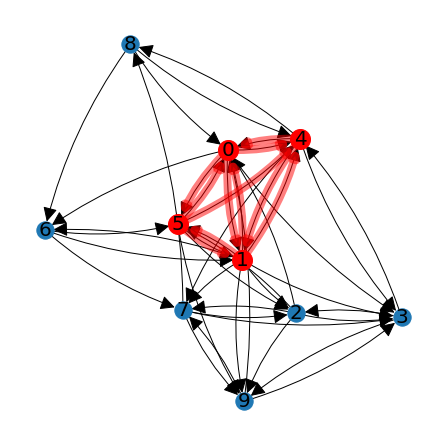

In [38]:
C = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if (R[i,j] == 1 and R[j,i] == 1):
            C[i,j] = 1

C_3 = C@C@C            
clique_nodes = []
for i in range(N):
    if (C_3[i,i] != 0):
        clique_nodes.append(i)
print(C_3)
lag.HighlightSubgraph(R,big_graph_positions,clique_nodes)

**Exercise 4:** Write a code cell to sort the $\texttt{clique_nodes}$ list into different cliques.  Print the result or store it in a list of lists.   

In [39]:
## Code solution here.

### References

- Anton, Howard and Chris Rorres. *Elementary Linear Algebra Applications Version*. 8th ed., John Wiley & Sons Inc., 2000. 

- Krebs, Charles J.; Boonstra, Rudy; Boutin, Stan (2017), Using experimentation to understand the 10‐year snowshoe hare cycle in the boreal forest of North America, Journal of Animal Ecology, Article-journal, https://doi.org/10.1111/1365-2656.12720

- Kwak, Jin Ho and Sungpyo Hong.  *Linear Algebra*. 2nd ed., Birkhauser., 2004.

- Williams, David, *Planetary Fact Sheet*, https://nssdc.gsfc.nasa.gov/planetary/factsheet/, NASA Goddard Space Flight Center, 2021